In [867]:
import numpy as np

# Using the natural language tookit for pre-processing
import nltk 
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('punkt')                # Tokenization package (word separators)
nltk.download('stopwords')            # Stopwords package (words with neutral connotation)


# We will be using sci-kit learn for vectorization, training, and testing
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

# Imports for graphing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/madikloberdanz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/madikloberdanz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Read the CSV file with tweets into a DataFrame.

In [868]:
tweets_df = pd.read_csv("Suicide_Ideation_Dataset(Twitter-based).csv")

upper_labels = []

# Make labels uppercase and underscored for clarity
for id in tweets_df["Suicide"].values:
  if id == "Not Suicide post":
    upper_labels.append("NOT_SUICIDE_POST")
  else:
    upper_labels.append("POTENTIAL_SUICIDE_POST")

tweets_df["Suicide"] = upper_labels

import pandas as pd

# Assuming tweets_df is your DataFrame containing the "Tweet" column
tweets_df = tweets_df.dropna(subset=["Tweet"])

tweets_df.head()

,Tweet,Suicide
0,making some lunch,NOT_SUICIDE_POST
1,@Alexia You want his money.,NOT_SUICIDE_POST
2,@dizzyhrvy that crap took me forever to put to...,POTENTIAL_SUICIDE_POST
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,NOT_SUICIDE_POST
4,Trying out &quot;Delicious Library 2&quot; wit...,NOT_SUICIDE_POST


### Pre-process the words by doing:
1. Tokenization
2. Lowercasing
3. Removing stop words
4. Removing punctuation, emojis, or special characters
5. Stemming words so that words like "regret" and "regretted" are treated the same

In [869]:

# Set of stop words
stop_words = set(stopwords.words('english'))

# Getting our stemmer
stemmer = PorterStemmer()

def preprocessor(tweets_df) -> list:

    # List to store tokenized words from all tweets
    tokenized_tweets = []                                       
    
    for tweet in tweets_df["Tweet"].values:
        if type(tweet) == str:

            # Lowercase and tokenize all words so that comparison is easy
            tweet_as_list = word_tokenize(tweet.lower())

            # Use a list comprehension to get rid of special characters
            words = [word for word in tweet_as_list if not re.match(r'[^a-z](,)?', word)]

            # Remove stop words
            filtered_words = [word for word in words if word not in stop_words]

            # Stem the words
            stemmed_words = [stemmer.stem(word) for word in filtered_words]

            # Finally, append to the list
            tokenized_tweets.append(stemmed_words)
            
        else:

            # In the 2 cases in the dataset where the tweet is not a string, just append it
            tokenized_tweets.append(tweet)

    return tokenized_tweets

# Using pre-processor
words_list = preprocessor(tweets_df)
tweets_df["Pre-processed"] = words_list

tweets_df

,Tweet,Suicide,Pre-processed
0,making some lunch,NOT_SUICIDE_POST,"[make, lunch]"
1,@Alexia You want his money.,NOT_SUICIDE_POST,"[alexia, want, money]"
2,@dizzyhrvy that crap took me forever to put to...,POTENTIAL_SUICIDE_POST,"[dizzyhrvi, crap, took, forev, put, togeth, iâ..."
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,NOT_SUICIDE_POST,"[jnaylor, kiwitweet, hey, jer, sinc, start, tw..."
4,Trying out &quot;Delicious Library 2&quot; wit...,NOT_SUICIDE_POST,"[tri, quot, delici, librari, quot, mix, result..."
...,...,...,...
1782,i have forgotten how much i love my Nokia N95-1,NOT_SUICIDE_POST,"[forgotten, much, love, nokia, n95-1]"
1783,Starting my day out with a positive attitude! ...,NOT_SUICIDE_POST,"[start, day, posit, attitud, great, watch, great]"
1784,"@belledame222 Hey, it's 5 am...give a girl som...",NOT_SUICIDE_POST,"[belledame222, hey, give, girl, credit, tri]"
1785,2 drunken besties stumble into my room and we ...,NOT_SUICIDE_POST,"[drunken, besti, stumbl, room, run, around, so..."


Now that the tweets are pre-processed, we can begin to find some meaning in them. Let's start making a classifier by first separating the data into a training and testing set. We will do 80% training and 20% testing after shuffling the tweets just in case they are in any particular order.

In [870]:
# Shuffle and reset the index so that we can easily grab the first 80% and bottom 20%
shuffled_tweets = tweets_df.sample(frac=1).reset_index()

# Assign training data set - first 80%
first_80p = int(len(tweets_df) * 0.8)
train_data = shuffled_tweets.iloc[np.arange(first_80p), :]

# Assign testing data set - bottom 20%
test_data = shuffled_tweets.iloc[np.arange(first_80p, len(shuffled_tweets)), :]

Before we can assess / vectorize each tweet, we need to build a vocabulary which we will use for comparing to other tweets.

While we are looking at all of the words, it would be beneficial in this case to remove words that only occur once in the whole dataset. This is mainly to remove names to narrow down what data is actually useful for classification.

After we build our vocabulary, let's add the frequencies of each word as the contents of the cells of our dataframe.

In [871]:
# Build the initial array of vocabulary words from all of the tweets
all_vocab = tweets_df["Pre-processed"].values

# Put all the words into one array without sub-lists, ignoring the NaN cases
vocab_array = []
for item in all_vocab:
    if not isinstance(item, float):
        for elem in item:
          vocab_array.append(elem)

# Count up how often the words in the vocab_array occur
word_counts = {}
for word in vocab_array:
  if word in word_counts:
    word_counts[word] += 1
  else:
    word_counts[word] = 1
   
# Make a new array of only the words we will use for classification
relevant_words = []
for word in word_counts:
   if word_counts[word] > 1:
      relevant_words.append(word)

Now that we have vectorized our tweets, we can finally begin training our model. We will be using sci-kit learn to do Naive-Bayes multinomial classification. In other words, we will predict the probability that "POTENTIAL_SUICIDE_POST" given x words are present in the tweet. Our features (X) are the wrods in the tweets, while our response variable (y) is the label.

In [872]:
# Select the data that we need
train_tweets = train_data["Pre-processed"]  # List of pre-processed training tweets
test_tweets = test_data["Pre-processed"]    # List of pre-processed test tweets
labels_train = train_data["Suicide"]        # Corresponding labels for training tweets
labels_test = test_data["Suicide"]          # Corresponding labels for test tweets

# Currently, each tweet is a list of strings ex: ["this", "is", "how", "tweets", "look"]
train_tweets = [" ".join(tweet_words) for tweet_words in train_tweets]
test_tweets = [" ".join(tweet_words) for tweet_words in test_tweets]

# Now train_tweets is a list of strings where each string contains the words of a pre-processed tweet
# ex: "this is how tweets look"
# Now the vectorizer can interpret this tweet

# Use the vectorizer
vectorizer = CountVectorizer(vocabulary=relevant_words) # Create an instance of the vectorizer
X_train = vectorizer.transform(train_tweets)            # Transform pre-processed tweets into a numerical feature matrix
X_test = vectorizer.transform(test_tweets)              # Gets the frequency of each word for each tweet

# Train the classifier
classifier = MultinomialNB()          # Create an instance of the classifier
classifier.fit(X_train, labels_train) # Fit the classifier on the training data along with the corresponding labels

# Calculate probabilities / predict
predicted_labels = classifier.predict(X_test)

# Evaluate the accuracy
print(classification_report(labels_test, predicted_labels))

                        precision    recall  f1-score   support

      NOT_SUICIDE_POST       0.97      0.84      0.90       228
POTENTIAL_SUICIDE_POST       0.77      0.96      0.86       129

              accuracy                           0.88       357
             macro avg       0.87      0.90      0.88       357
          weighted avg       0.90      0.88      0.88       357



Let's interpret this classification report. Since the labels are shuffled each time the code is run, the numbers mentioned here will vary. Currently this is the report:

|                   | precision | recall | f1-score | support |
|-------------------|-----------|--------|----------|---------|
| NOT_SUICIDE_POST  | 0.94      | 0.82   | 0.88     | 204     |
| POTENTIAL_SUICIDE_POST | 0.80  | 0.93   | 0.86     | 153     |
| accuracy          |           |        | 0.87     | 357     |
| macro avg         | 0.87      | 0.88   | 0.87     | 357     |
| weighted avg      | 0.88      | 0.87   | 0.87     | 357     |


### The difference between precision and recall:
#### Precision

Precision focuses on the accuracy of positive predictions made by the classifier. It answers the question: "Of all the instances predicted as positive, how many are actually positive?"

Mathematically, precision is defined as:

Precision = TP / (TP + FP)

Where:

TP (True Positives) are the instances correctly predicted as positive.
FP (False Positives) are the instances incorrectly predicted as positive when they are actually negative.

"If the classifier predicts POTENTIAL_SUICIDE_POST, the probability that it is indeed POTENTIAL_SUICIDE_POST."

#### Recall
Recall, also known as sensitivity or true positive rate, focuses on the ability of the classifier to correctly identify all positive instances. It answers the question: "Of all the actual positive instances, how many did the classifier correctly predict?"

Mathematically, recall is defined as:

Recall = TP / (TP + FN)

Where:

TP (True Positives) are the instances correctly predicted as positive.
FN (False Negatives) are the instances incorrectly predicted as negative when they are actually positive.

"If a tweet is truly POTENTIAL_SUICIDE_POST, the probability that the classifier will correctly identify it as POTENTIAL_SUICIDE_POST."

### f1-score
The F1-score is the harmonic mean of precision and recall. It provides a balanced measure that considers both false positives and false negatives. An F1-score of 0.88 for the "NOT_SUICIDE_POST" class indicates a good balance between precision and recall for that class.

### Support
Support represents the number of instances of each class in the test dataset. For "NOT_SUICIDE_POST," there are 204 instances, and for "POTENTIAL_SUICIDE_POST," there are 153 instances.

### Accuracy
Accuracy is the overall proportion of correctly predicted instances among all instances. The overall accuracy of the model is 0.87, which means that 87% of the instances in the test dataset were classified correctly.

### Macro average
The macro average is the average of precision, recall, and F1-score across all classes. In this case, it's approximately 0.87, indicating a balanced performance across classes.

### Weighted average
The weighted average takes into account the class distribution. It's calculated by weighting the metrics by the support of each class. The weighted average F1-score (0.87) indicates the overall model performance, considering the number of instances in each class.  


#### ------------------------------------------------------------------------------------------------------------------------------------------------------

### Data visualizations
To better understand where our model falls short, let's see how it does classifying different lengths of tweets.

In [873]:
suicide_tweets = (tweets_df[tweets_df["Suicide"] == "POTENTIAL_SUICIDE_POST"]).drop(["Tweet"], axis=1)
not_suicide_tweets = tweets_df[tweets_df["Suicide"] == "NOT_SUICIDE_POST"].drop(["Tweet"], axis=1)

def get_tweet_length(suicide_or_not) -> list[int]:
  lengths = []
  for tweet in suicide_or_not["Pre-processed"]:
    length = len(tweet)
    lengths.append(length)
  return lengths

suicide_tweets_length = get_tweet_length(suicide_tweets)
not_suicide_tweets_length = get_tweet_length(not_suicide_tweets)

suicide_tweets.loc[:,"length"] = suicide_tweets_length
not_suicide_tweets.loc[:, "length"] = not_suicide_tweets_length

suicide_tweets


,Suicide,Pre-processed,length
2,POTENTIAL_SUICIDE_POST,"[dizzyhrvi, crap, took, forev, put, togeth, iâ...",11
7,POTENTIAL_SUICIDE_POST,"[jakepaul, jamescharl, loganpaul, shane, made,...",13
9,POTENTIAL_SUICIDE_POST,"[hate, life, lmao, hope, die, soon, sumn, tire...",9
13,POTENTIAL_SUICIDE_POST,"[aw, habit, avoid, write, paper, watch, instag...",14
16,POTENTIAL_SUICIDE_POST,"[akwesiquan, animeesay, want, say, ill, never,...",16
...,...,...,...
1775,POTENTIAL_SUICIDE_POST,"[rt, kindfashionni, pleas, see, need, human, d...",14
1776,POTENTIAL_SUICIDE_POST,"[know, damn, well, hate, take, anyway, http]",7
1778,POTENTIAL_SUICIDE_POST,"[damn, crazi, life, mine]",4
1779,POTENTIAL_SUICIDE_POST,"[day, feel, deepli, depress, highli, sensit, p...",52


Plot the distribution of tweet lengths (in terms of word count) for NOT_SUICIDE_POST.

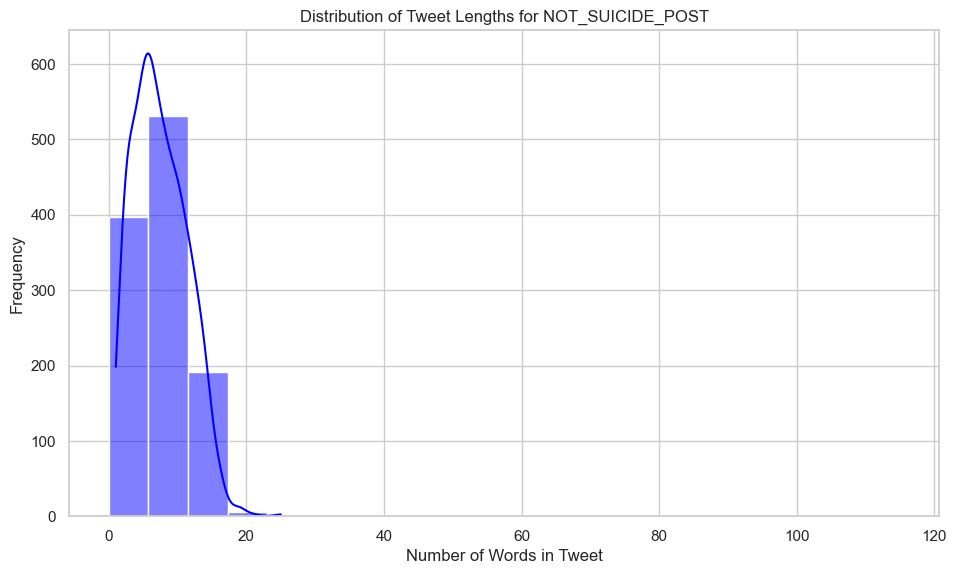

Summary of NOT_SUICIDE:
 count    1126.000000
mean        7.486679
std         3.885620
min         1.000000
25%         4.000000
50%         7.000000
75%        10.000000
max        25.000000
dtype: float64
 median: 7.0


In [874]:
x_range = (0, max(suicide_tweets_length)) 

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(not_suicide_tweets_length, bins=20, kde=True, color="blue", binrange=x_range)
plt.title(f"Distribution of Tweet Lengths for NOT_SUICIDE_POST")
plt.xlabel("Number of Words in Tweet")
plt.ylabel("Frequency")

plt.show()

# Five-number summary
not_suicide_summary = pd.Series(not_suicide_tweets_length).describe(percentiles=[.25, .50, .75])
print(f"Summary of NOT_SUICIDE:\n {not_suicide_summary}\n median: {(pd.Series(not_suicide_tweets_length)).median()}")

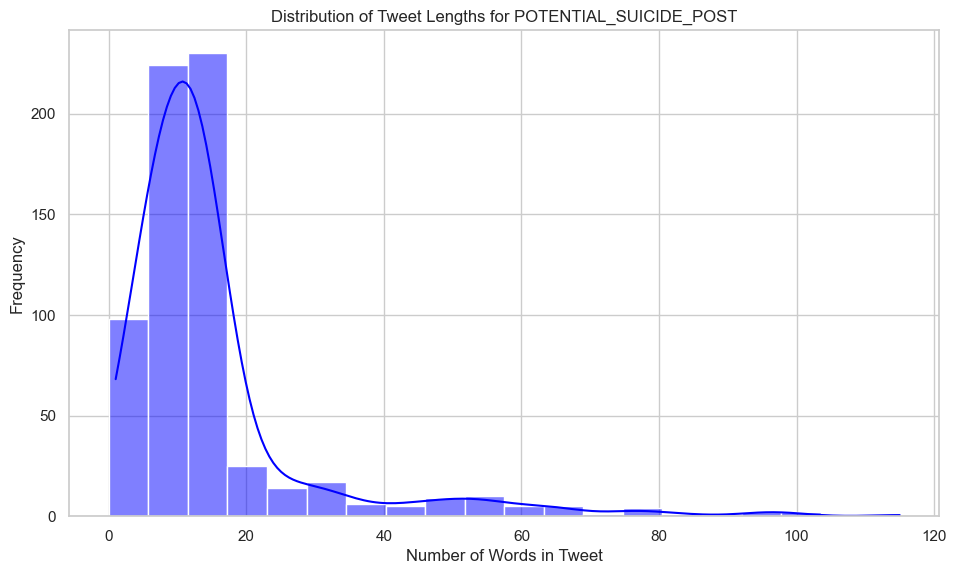

Summary of SUICIDE:
 count    659.000000
mean      15.054628
std       14.832091
min        1.000000
25%        8.000000
50%       12.000000
75%       15.000000
max      115.000000
dtype: float64 
 median: 12.0


In [875]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(suicide_tweets_length, bins=20, kde=True, color="blue", binrange=x_range)
plt.title(f"Distribution of Tweet Lengths for POTENTIAL_SUICIDE_POST")
plt.xlabel("Number of Words in Tweet")
plt.ylabel("Frequency")

plt.show()

# Five-number summary
suicide_summary = pd.Series(suicide_tweets_length).describe(percentiles=[.25, .50, .75])
print(f"Summary of SUICIDE:\n {suicide_summary} \n median: {(pd.Series(suicide_tweets_length)).median()}")

The differences between these distributions is very interesting. Originally, it appeared that the NOT_SUICIDE_POST tweets had more variation because the distributionn was spread out more. When I changed the scale to be the same as the POTENTIAL_SUICIDE_POST scale and added a summary, it became clear that there is much more variation in the POTENTIAL_SUICIDE_POST category. We can do hypothesis testing to see if this difference is statistically significant.
### Hypothesis testing

Since the distributions aren't normally distributed and variance between the groups is not equal, we are limited in the tests that we can do. We can do a Mann-Whitney U test or a Welch's t-test. We will do a Welch's t-test, since we want to compare the groups' means and not their distributions.


Step 1: Null and Alternative hypotheses: <br/>
H0: there is no difference between the average word length of POTENTIAL_SUICIDE_POST tweets and NOT_SUICIDE_POST tweets.
Ha: there is a difference between the average word length of POTENTIAL_SUICIDE_POST tweets and NOT_SUICIDE_POST tweets.

In [876]:
n1 = len(suicide_tweets_length)
n2 = len(not_suicide_tweets_length)

# Step 2: Calcualte the means of the two samples
x1 = pd.Series(suicide_tweets_length).mean()
x2 = pd.Series(not_suicide_tweets_length).mean()

# Step 3: Calculate the standard deviations of the two samples
s1 = pd.Series(suicide_tweets_length).std()
s2 = pd.Series(not_suicide_tweets_length).std()

# Step 4: Calculate the t-value 
t_val = (x1 - x2) / (np.sqrt((s1 ** 2 / n1)) + (s2 ** 2 / n2))

# Step 5: Calculate the degrees of freedom
numerator = ((s1 ** 2 / n1) + (s2 ** 2 / n2)) ** 2
denominator = (
    ((s1 ** 2 / n1) ** 2 / (n1 - 1)) + ((s2 ** 2 / n2) ** 2 / (n2 - 1))
)
v = numerator/denominator
print("t-value:", t_val)
print("Degrees of Freedom:", v)

t-value: 12.801326375242652
Degrees of Freedom: 711.249412414707


We should calculate the p-value to make a conclusion.
The p-value is the chance that, if there is no difference in the tweet lengths, the test statistic (t-value) is equal to 12.8 or is even further in the direction of the alternative.

In [877]:
import scipy.stats as stats

# Calculate the p-value
p_value = 2 * (1 - stats.t.cdf(abs(t_val), df=v))

print("p-value:", p_value)

p-value: 0.0


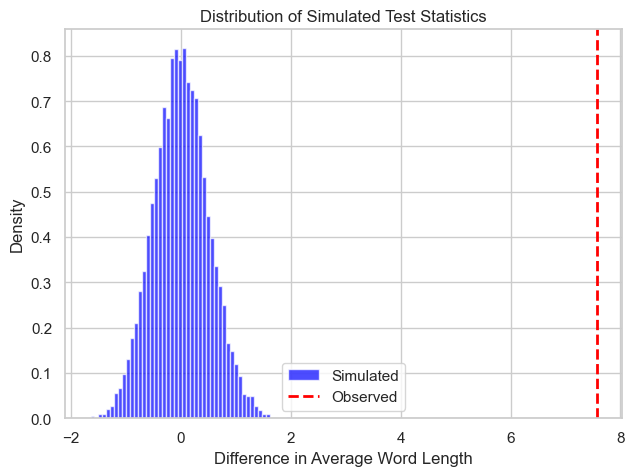

Reject null hypothesis


In [878]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate observed difference
observed_diff = np.mean(suicide_tweets_length) - np.mean(not_suicide_tweets_length)

# Pool data
pooled_data = np.concatenate((suicide_tweets_length, not_suicide_tweets_length))

# Number of simulations
num_simulations = 10000

# Initialize an array to store simulated test statistics
simulated_diffs = []

# Simulation loop
for _ in range(num_simulations):
    # Shuffle labels and calculate test statistic
    np.random.shuffle(pooled_data)
    simulated_diff = np.mean(pooled_data[:len(suicide_tweets_length)]) - np.mean(pooled_data[len(suicide_tweets_length):])
    simulated_diffs.append(simulated_diff)

# Calculate p-value
p_value = (np.abs(simulated_diffs) >= np.abs(observed_diff)).mean()

# Plot the distribution of simulated test statistics
plt.hist(simulated_diffs, bins=50, density=True, alpha=0.7, color='blue', label='Simulated')
plt.axvline(x=observed_diff, color='red', linestyle='dashed', linewidth=2, label='Observed')
plt.xlabel('Difference in Average Word Length')
plt.ylabel('Density')
plt.title('Distribution of Simulated Test Statistics')
plt.legend()
plt.show()

# Compare with significance level (e.g., 0.05)
if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")


By comparing this to a two-sided t-test table, using an alpha level of 0.05 and 1000 degrees of freedom, we get a critical value of 1.962. Our calculated t-value is much higher than this, at 12.801. We also obtained a p-value of about 0.0, meaning there is about a 0.0% chance that the differences observed in the tweet lengths occured due to random chance. This can be seen by comparing the simulated differences above and the observed difference.

We can say that the tweets labeled "POTENTIAL_SUICIDE_POST" tend to be longer, which is suggestive of the mental state of the user. Maybe it is that longer tweets equates to having more mental stress or even anger. We cannot say for certain why these tweets are longer, but it is clear that tweet length is a factor. 

It may be worth noting that this statistical test was done on the pre-processed tweets, meaning that tweets marked as "POTENTIAL_SUICIDE_POST" tend to have more words that have been determined to hold more meaning since stopwords, names, and special characters were removed.